데이터 https://github.com/wikibook/python-real-estate/tree/master/%EB%8D%B0%EC%9D%B4%ED%84%B0

In [1]:
import pandas as pd

def get_province(x):
    temp = x.split(' ')[0]
    if len(temp) != 4:
        return temp[:2]
    else:
        return temp[0] + temp[2]


def job_preprocessing(path):
    job_raw = pd.read_excel(path, skiprows=1)
    job_data = job_raw[job_raw['산업별'] == '전산업']
    job_data = job_data[['지역별', '전체종사자']]
    job_data.columns = ['지역명',  '고용자수']
    
    job_data['시도'] = job_data['지역명'].apply(get_province)
    job_data['구군'] = job_data['지역명'].apply(lambda x: x.split(' ')[1])
    
    return job_data

def house_number_preprocessing(path):
    house_raw = pd.read_excel(path)
    house_raw.columns = ['시도', '구군', '세대수']

    big_col = []
    for num, temp in enumerate(house_raw['시도']):
        if pd.isna(temp) :
            big_col.append(big_col[num-1])
        else:
            big_col.append(temp)
    house_raw['시도'] = big_col
    
    house_raw['시도'] = house_raw['시도'].apply(get_province)
    house_data = house_raw[house_raw['구군'] != '소계']
    
    return house_data

In [2]:
job_path = f'data/과제1_지역고용통계_20190706075534.xlsx'
job_df = job_preprocessing(job_path)

In [3]:
house_path = f'data/과제1_행정구역_시군구_별_주민등록세대수_20190706074416.xlsx'
house_df = house_number_preprocessing(house_path)

In [4]:
job_sido = job_df.groupby('시도').sum()
job_sido = job_sido.sort_values(by='고용자수', ascending=False)

# Q) 과제1_평균매매가격_아파트.xlsx 파일을 업로드 하고, house_price_preprocessing을 사용해서 데이터를 전처리 하라.

In [5]:
def house_price_preprocessing(path):
    row_price = pd.read_excel(path, skiprows=10)
    
    big_col = []
    for num, temp in enumerate(row_price['지 역']):
        if pd.isna(temp) :
            big_col.append(big_col[num-1])
        else:
            big_col.append(temp)


    small_col = []
    for num in range(len(row_price)):
        temp_list = list(row_price[['지 역', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3']].iloc[num])
        for temp in temp_list[3::-1]:
            if not pd.isna(temp):
                small_col.append(temp)
                break

    row_price.index = [big_col, small_col]
    
    transposed_price = row_price.drop(['지 역', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3'], axis=1).T
    
    time_index = []
    for time in transposed_price.index:
        temp = time.split(' ')
        time_index.append(temp[0][:-1]+'.'+temp[1][:-1])

    transposed_price.index = pd.to_datetime(time_index)
    
    return transposed_price

price_path = f'data/과제2_평균매매가격_아파트.xlsx'
price_df = house_price_preprocessing(price_path)

# Q) 데이터 분석 및 이미지 출력을 위한 설정을 진행하세요.

In [6]:
# 1. 라이브러리 호출
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 2. 시각화 설정
from matplotlib import font_manager, rc
from matplotlib import style
style.use('ggplot')
%matplotlib inline

# 3. 한글폰트 설정
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False

# 4. 해상도
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

# Q) 시도 단위의 고용자수를 막대 그래프로 보기 

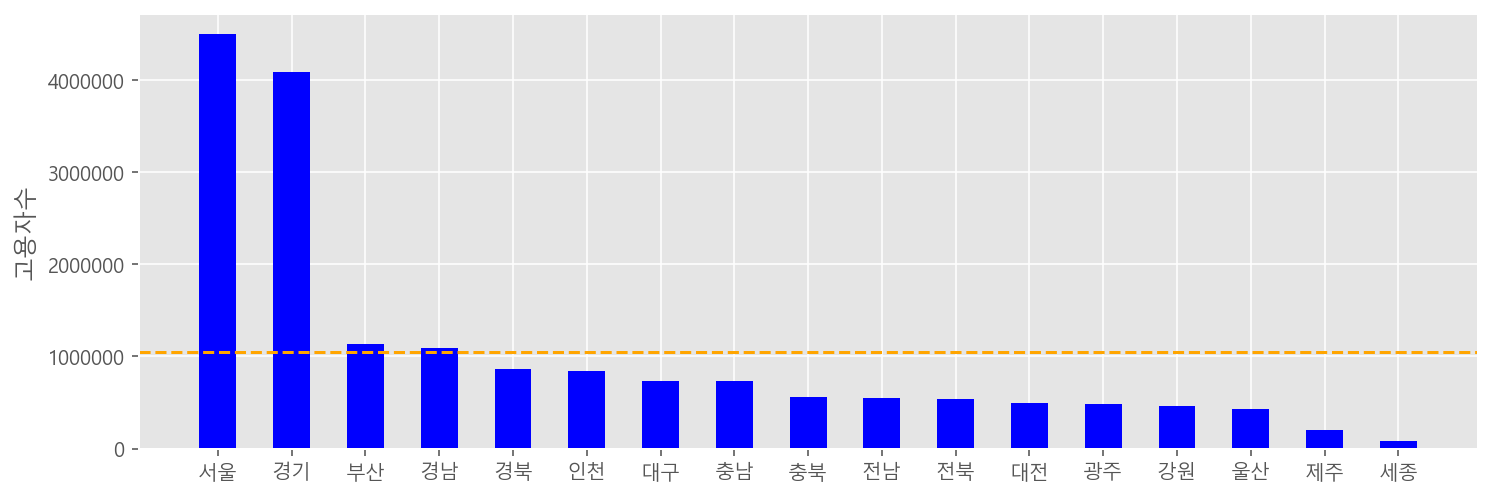

In [7]:
fig, ax = plt.subplots(figsize = (12,4))
ax.axhline(job_sido['고용자수'].mean(), ls='--', color='orange')
plot = ax.bar(job_sido.index, job_sido['고용자수'],color='blue',width = 0.5)
plt.ylabel('고용자수')
plt.show()

# Q) 시도 단위 세대구 대비 고용비율 막대 그래프로 보기

In [8]:
household_employee = house_df.groupby('시도').sum()
job_sido['세대수'] = household_employee['세대수']
job_sido['세대수_대비_고용비율'] =  (job_sido['고용자수'] / job_sido['세대수']) *100
job_sido = job_sido.sort_values(by='세대수_대비_고용비율', ascending=False)

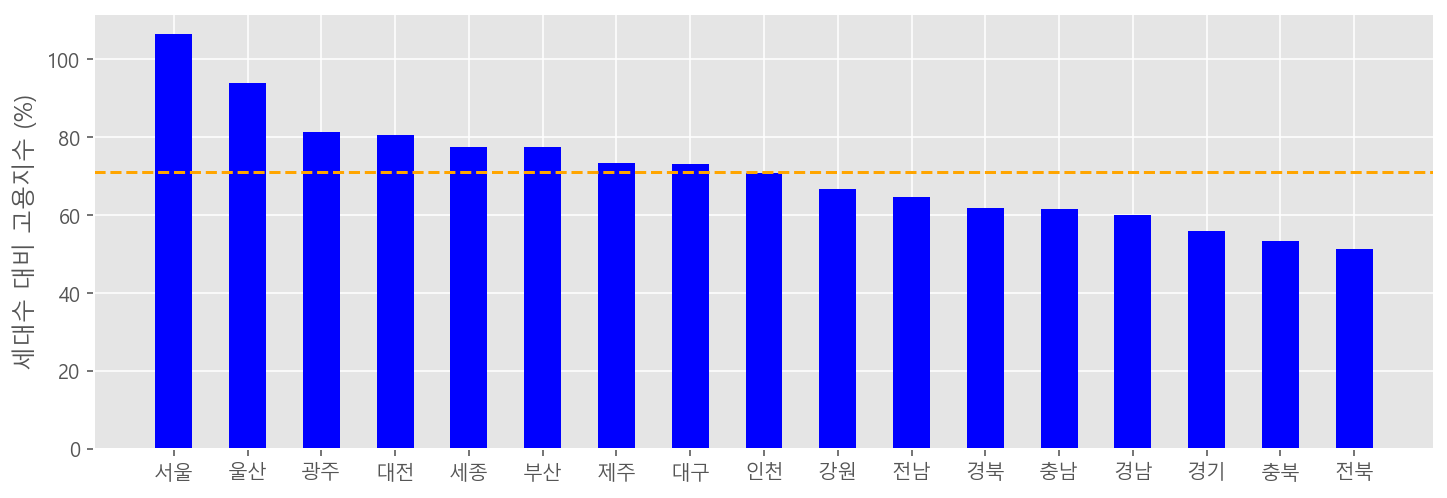

In [9]:
fig, ax = plt.subplots(figsize = (12,4))
ax.axhline(job_sido['세대수_대비_고용비율'].mean(), ls='--', color='orange')
plot = ax.bar(job_sido.index, job_sido['세대수_대비_고용비율'],color='blue',width = 0.5)
plt.ylabel('세대수 대비 고용지수 (%)')
plt.show()

# 고용자수, 세대수, 평균 아파트 매매가격 scatter 그래프로 나타내기
* 아래 예제는 scatter 예제 입니다. 아래 코드를 잘 분석해서 아래 문제를 해결해보세요.

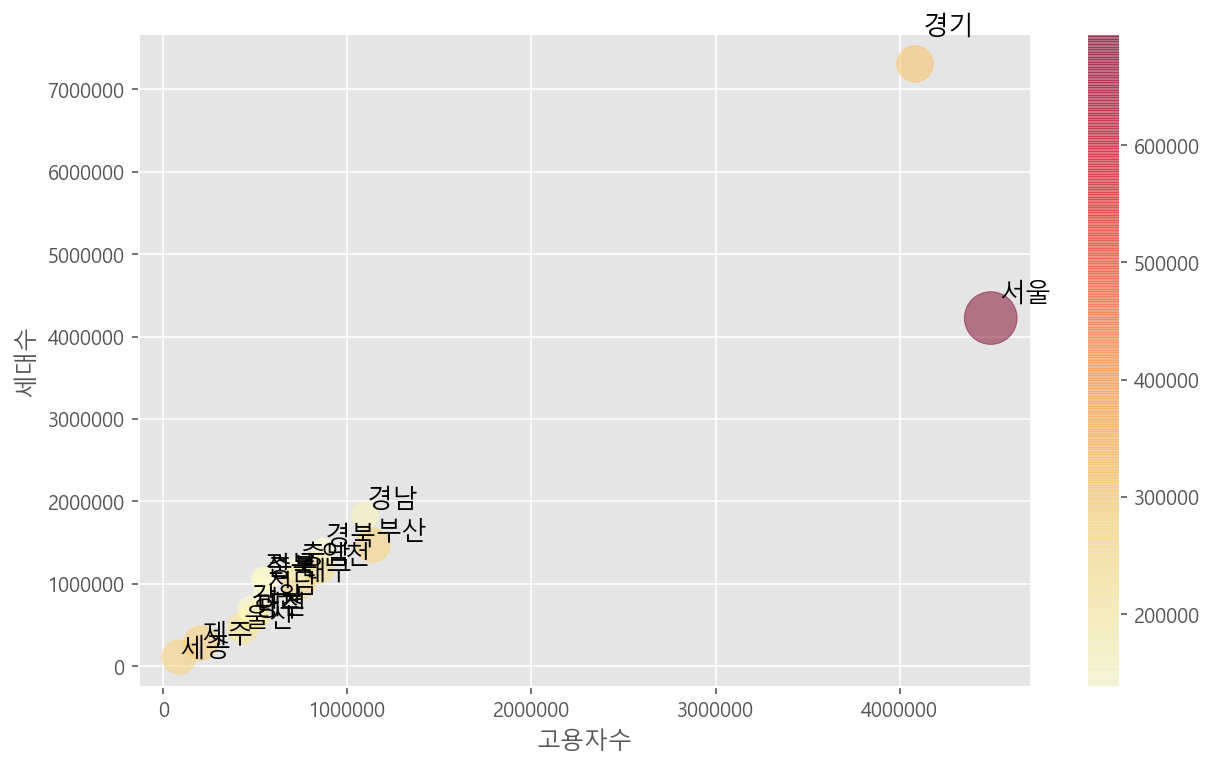

In [10]:
sido_list = []
for i in job_sido.index:
    sido_list.append(price_df.loc['2018-6-1'][i][i])
      
job_sido['평균매매가격'] = sido_list

plt.figure(figsize=(10, 6))
plt.scatter(job_sido['고용자수'], job_sido['세대수'], c=job_sido['평균매매가격'], s=job_sido['평균매매가격']*0.001, cmap="YlOrRd", alpha=0.5 )
plt.xlabel('고용자수')
plt.ylabel('세대수')
for name in job_sido.index:
    plt.text(job_sido['고용자수'][name]*1.01, job_sido['세대수'][name]*1.05, name, fontsize=13)

plt.colorbar()
plt.show()

# Q) 세대수 대비 고용비율, 세대수, 평균 아파트 매매가격 scatter 그래프로 나타내기

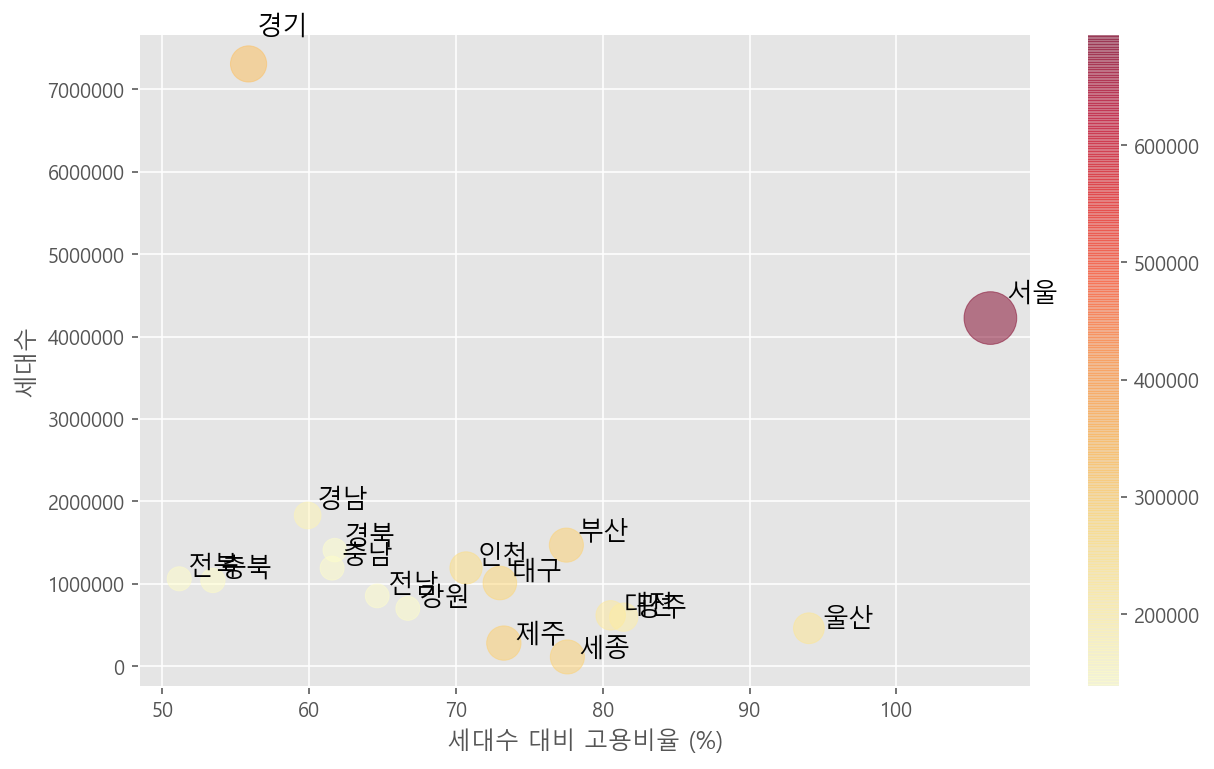

In [11]:
sido_list = []
for i in job_sido.index:
    sido_list.append(price_df.loc['2018-6-1'][i][i])

job_sido['평균매매가격'] = sido_list
plt.figure(figsize=(10, 6))
plt.scatter(job_sido['세대수_대비_고용비율'], job_sido['세대수'], c=job_sido['평균매매가격'], s=job_sido['평균매매가격']*0.001, cmap="YlOrRd", alpha=0.5 )
plt.xlabel('세대수 대비 고용비율 (%)')
plt.ylabel('세대수')
for name in job_sido.index:
    plt.text(job_sido['세대수_대비_고용비율'][name]*1.01, job_sido['세대수'][name]*1.05, name, fontsize=13)

plt.colorbar()
plt.show()

# Q) 부산시의 구군별 고용자수

In [12]:
job_pusan_df = job_df[job_df['시도'] == '부산']
job_pusan_kukun = job_pusan_df.groupby('구군').sum()
job_pusan_kukun = job_pusan_kukun.sort_values(by='고용자수', ascending=False)

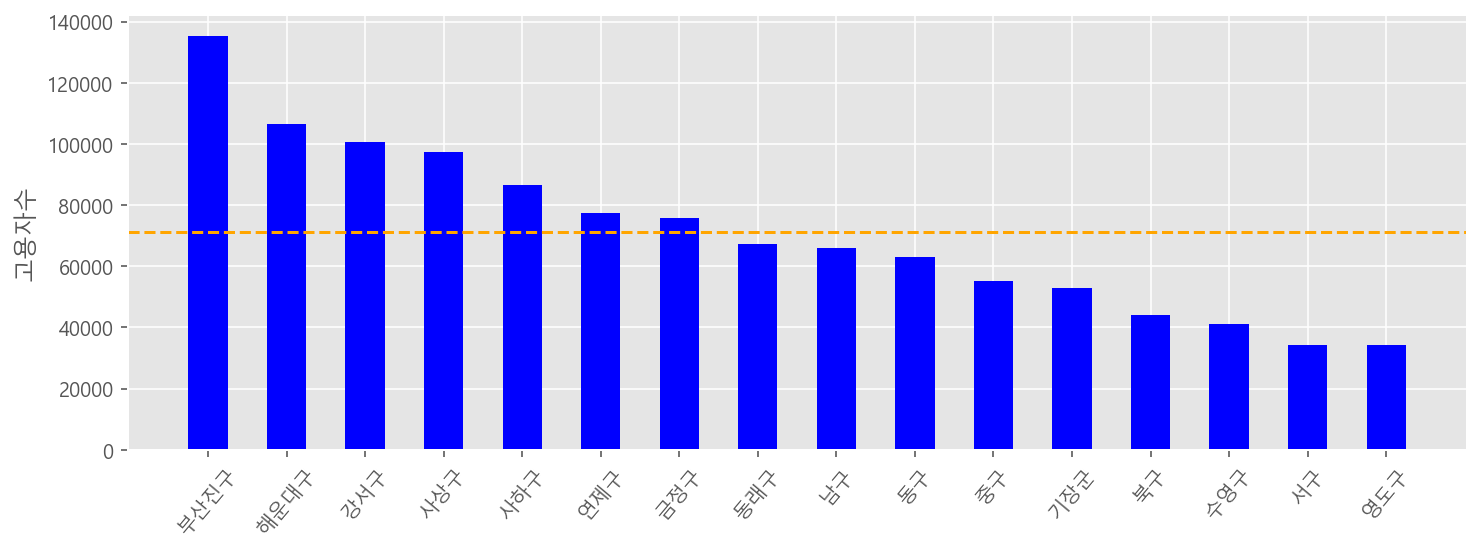

In [13]:
fig, ax = plt.subplots(figsize = (12,4))
plt.xticks(rotation = 50)
ax.axhline(job_pusan_kukun['고용자수'].mean(), ls='--', color='orange')
plot = ax.bar(job_pusan_kukun.index, job_pusan_kukun['고용자수'],color='blue',width = 0.5)
plt.ylabel('고용자수')
plt.show()

# Q) 부산시의 구군별 고용비율(세대수 대비 고용자수)

In [14]:
pusan_house_employee = house_df[house_df['시도'] == '부산']
pusan_house_employee = pusan_house_employee.groupby('구군').sum()
job_pusan_kukun['세대수'] = pusan_house_employee['세대수']
job_pusan_kukun['세대수_대비_고용비율'] =  (job_pusan_kukun['고용자수'] / job_pusan_kukun['세대수']) *100
job_pusan_kukun = job_pusan_kukun.sort_values(by='세대수_대비_고용비율', ascending=False)

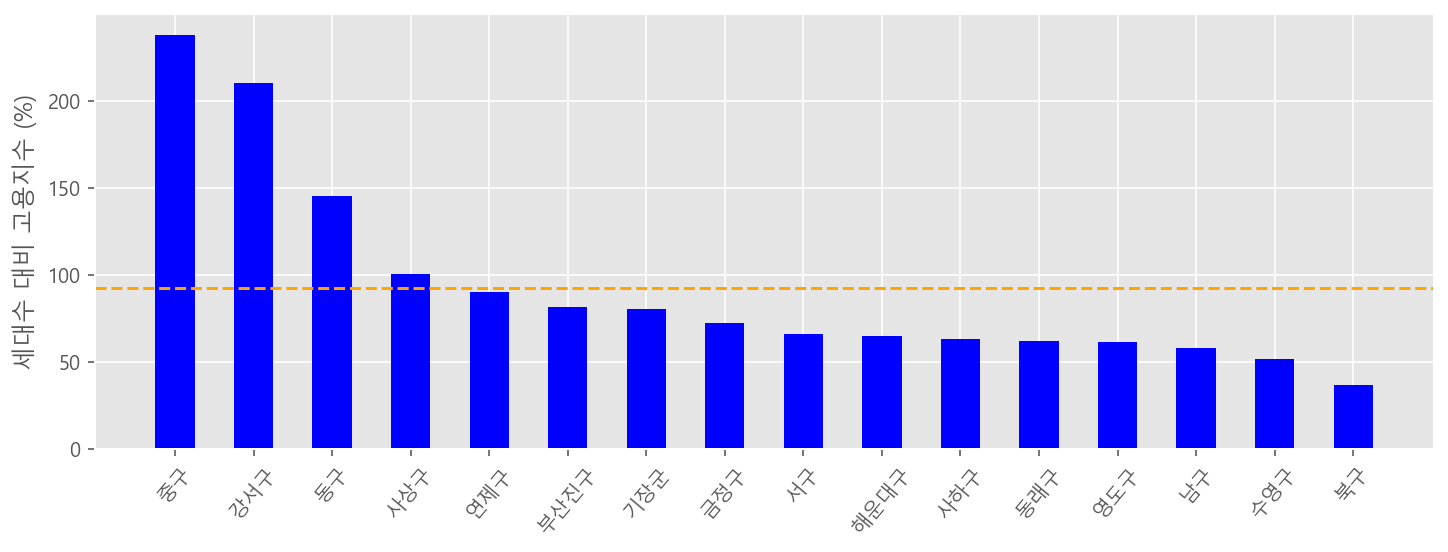

In [15]:
fig, ax = plt.subplots(figsize = (12,4))
ax.axhline(job_pusan_kukun['세대수_대비_고용비율'].mean(), ls='--', color='orange')
plt.xticks(rotation = 50)
plot = ax.bar(job_pusan_kukun.index, job_pusan_kukun['세대수_대비_고용비율'],color='blue',width = 0.5)
plt.ylabel('세대수 대비 고용지수 (%)')
plt.show()

# Q) 부산시의 고용자수, 세대수, 평균 아파트 매매가로 scatter 그래프 그리기

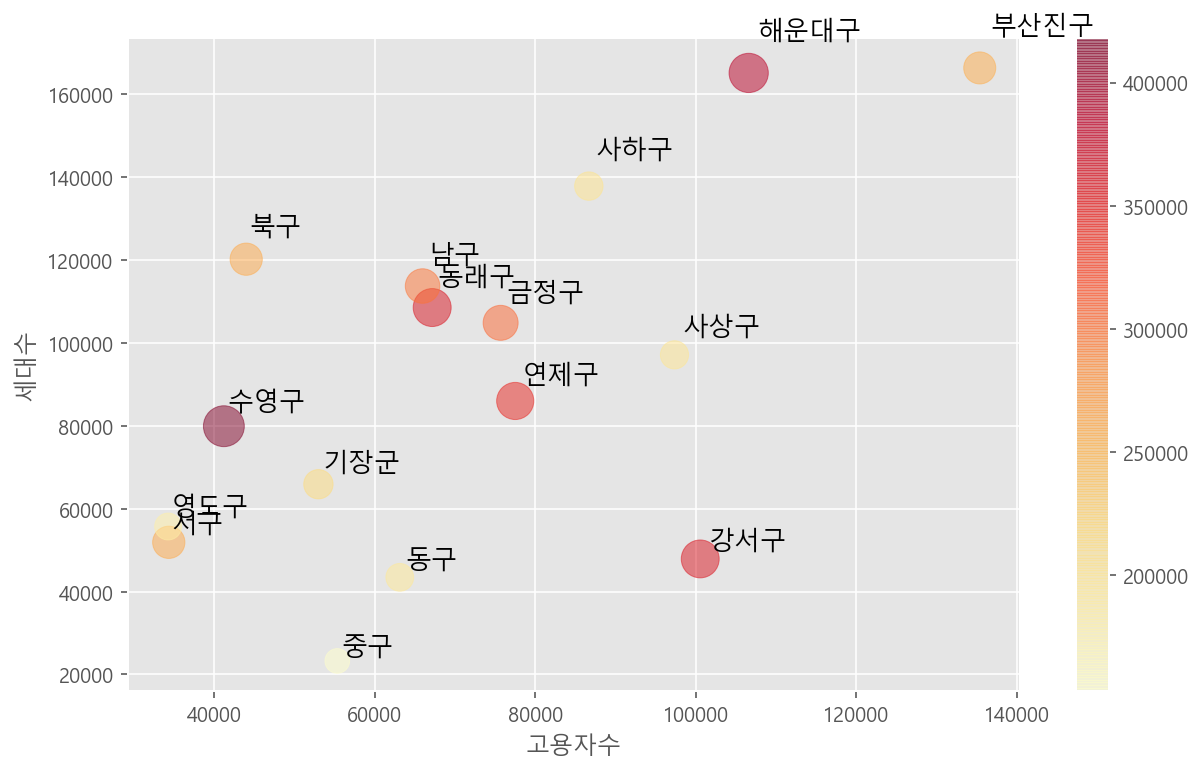

In [16]:
kukun_list = []
for i in job_pusan_kukun.index:
    kukun_list.append(price_df.loc['2018-6-1']['부산'][i])
      
job_pusan_kukun['평균매매가격'] = kukun_list

plt.figure(figsize=(10, 6))
plt.scatter(job_pusan_kukun['고용자수'], job_pusan_kukun['세대수'], c=job_pusan_kukun['평균매매가격'], s=job_pusan_kukun['평균매매가격']*0.001, cmap="YlOrRd", alpha=0.5 )
plt.xlabel('고용자수')
plt.ylabel('세대수')
for name in job_pusan_kukun.index:
    plt.text(job_pusan_kukun['고용자수'][name]*1.01, job_pusan_kukun['세대수'][name]*1.05, name, fontsize=13)

plt.colorbar()
plt.show()

# Q) 부산시의 고용비율, 세대수, 평균 아파트 매매가로 scatter 그래프 그리기

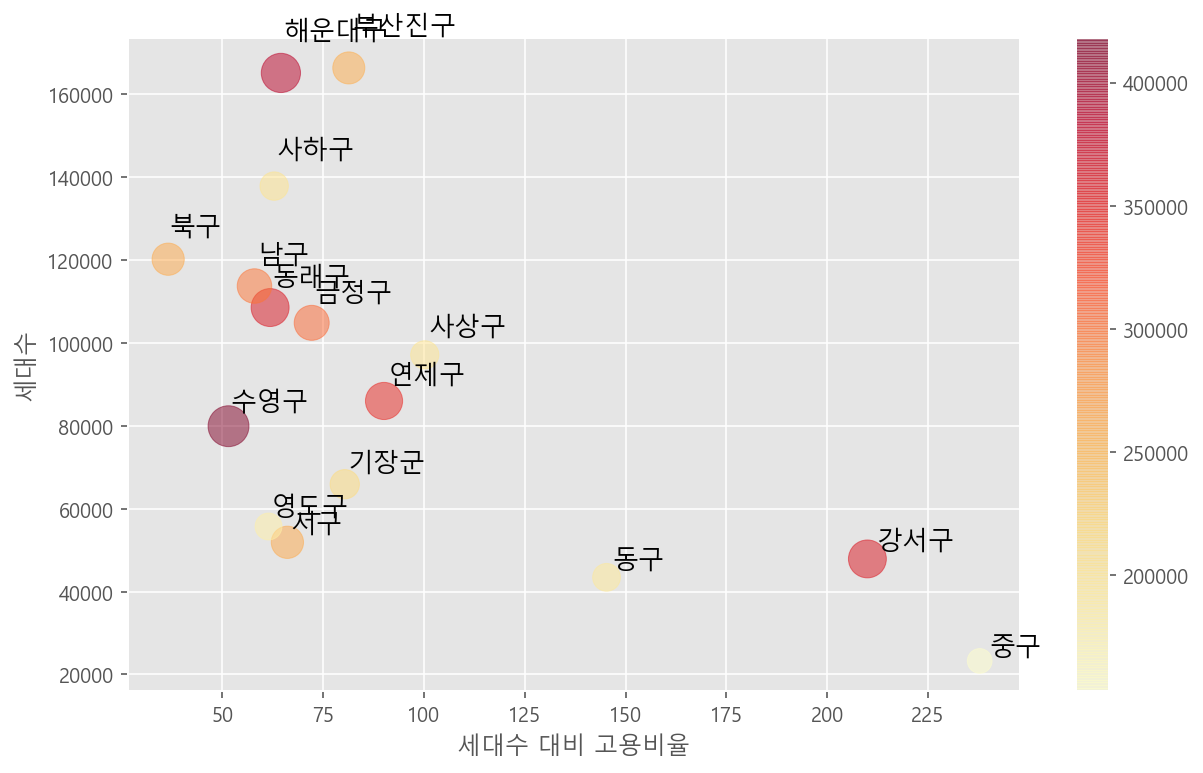

In [17]:
kukun_list = []
for i in job_pusan_kukun.index:
    kukun_list.append(price_df.loc['2018-6-1']['부산'][i])
      
job_pusan_kukun['평균매매가격'] = kukun_list

plt.figure(figsize=(10, 6))
plt.scatter(job_pusan_kukun['세대수_대비_고용비율'], job_pusan_kukun['세대수'], c=job_pusan_kukun['평균매매가격'], s=job_pusan_kukun['평균매매가격']*0.001, cmap="YlOrRd", alpha=0.5 )
plt.xlabel('세대수 대비 고용비율')
plt.ylabel('세대수')
for name in job_pusan_kukun.index:
    plt.text(job_pusan_kukun['세대수_대비_고용비율'][name]*1.01, job_pusan_kukun['세대수'][name]*1.05, name, fontsize=13)

plt.colorbar()
plt.show()